In [526]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

data = pd.read_csv('train.csv')

In [527]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [528]:
###drop pax id###
data.drop('PassengerId', axis=1, inplace=True)
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [529]:
###count nulls###
data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [530]:
###get unique titles from names###
data['Name'] = data['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
titles = data['Name'].unique()
titles

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [531]:
#### fill null ages with median for title###

data['Age'].fillna(-1, inplace=True)

medians = dict()
for title in titles:
    median = data.Age[(data["Age"] != -1) & (data['Name'] == title)].median()
    medians[title] = median
    
for index, row in data.iterrows():
    if row['Age'] == -1:
        data.loc[index, 'Age'] = medians[row['Name']]

data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,Mrs,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,Mr,male,35.0,0,0,373450,8.0500,NaN,S


In [532]:
###create ordinal feature based on survival###

replacement = {
    'Don': 0,
    'Rev': 0,
    'Jonkheer': 0,
    'Capt': 0,
    'Mr': 1,
    'Dr': 2,
    'Col': 3,
    'Major': 3,
    'Master': 4,
    'Miss': 5,
    'Mrs': 6,
    'Mme': 7,
    'Ms': 7,
    'Mlle': 7,
    'Sir': 7,
    'Lady': 7,
    'the Countess': 7
}

data['Name'] = data['Name'].apply(lambda x: replacement.get(x))

from sklearn.preprocessing import StandardScaler
data['Name'] = StandardScaler().fit_transform(data['Name'].values.reshape(-1, 1))

C:\Users\ThomasM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [533]:
###scale age###
data['Age'] = StandardScaler().fit_transform(data['Age'].values.reshape(-1, 1))

In [534]:
###replce zero fare with null###
data['Fare'].replace(to_replace=0, value=np.nan, inplace=True)

In [535]:
###replace null fare with median for passenger class###
data['Fare'].fillna(-1, inplace=True)
medians = dict()
for pclass in data['Pclass'].unique():
    median = data.Fare[(data["Fare"] != -1) & (data['Pclass'] == pclass)].median()
    medians[pclass] = median
for index, row in data.iterrows():
    if row['Fare'] == -1:
        data.loc[index, 'Fare'] = medians[row['Pclass']]
data['Fare'] = StandardScaler().fit_transform(data['Fare'].values.reshape(-1, 1))

In [536]:
###scale passenger class###

data['Pclass'] = StandardScaler().fit_transform(data['Pclass'].values.reshape(-1, 1))

C:\Users\ThomasM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [537]:
### new feature family based on number siblings or parent or children  onboard. is a count of family on board
data['Family'] = data['SibSp'] + data['Parch']

In [538]:
###drop the now unused cols
data.drop(['Parch','SibSp'], axis=1, inplace=True)

In [539]:
###turn family into ordinal based onsurvival rates in train set###

replacement = {
    7: 0,
    10: 0,
    5: 1,
    4: 2,
    0: 3,
    3: 3,
    6: 3,
    1: 4,
    2: 4
}
data['Family'] = data['Family'].apply(lambda x: replacement.get(x))
data['Family'] = StandardScaler().fit_transform(data['Family'].values.reshape(-1, 1))

C:\Users\ThomasM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [540]:
### drop ticket field ###
data.drop('Ticket', axis=1, inplace=True)


In [541]:
data.isnull().sum()
###recheck nulls###

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
Fare          0
Cabin       687
Embarked      2
Family        0
dtype: int64

In [542]:
###replace nulls with most common###
data['Embarked'].fillna('S', inplace=True)

In [543]:
data['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [544]:
###create ordinal again
replacement = {
    'S': 0,
    'Q': 1,
    'C': 2
}

data['Embarked'] = data['Embarked'].apply(lambda x: replacement.get(x))
data['Embarked'] = StandardScaler().fit_transform(data['Embarked'].values.reshape(-1, 1))
data.head()['Embarked']

C:\Users\ThomasM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0   -0.585954
1    1.942303
2   -0.585954
3   -0.585954
4   -0.585954
Name: Embarked, dtype: float64

In [545]:
data['Cabin'].fillna('U', inplace=True)
data['Cabin'] = data['Cabin'].apply(lambda x: x[0])
data['Cabin'].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [546]:
###ordinal for cabin based on survival###
replacement = {
    'T': 0,
    'U': 1,
    'A': 2,
    'G': 3,
    'C': 4,
    'F': 5,
    'B': 6,
    'E': 7,
    'D': 8
}

data['Cabin'] = data['Cabin'].apply(lambda x: replacement.get(x))
data['Cabin'] = StandardScaler().fit_transform(data['Cabin'].values.reshape(-1, 1))
data.head()['Cabin']

C:\Users\ThomasM\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0   -0.494813
1    0.960231
2   -0.494813
3    0.960231
4   -0.494813
Name: Cabin, dtype: float64

In [547]:
###encode sex
from sklearn.preprocessing import LabelEncoder
data['Sex'] = LabelEncoder().fit_transform(data['Sex'])

In [548]:
data.head()

,Survived,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,Family
0,0,0.827377,-0.797294,1,-0.557420,-0.513057,-0.494813,-0.585954,1.143445
1,1,-1.566107,1.537975,0,0.649410,0.778359,0.960231,1.942303,1.143445
2,1,0.827377,1.070922,0,-0.255712,-0.499444,-0.494813,-0.585954,-0.259874
3,1,-1.566107,1.537975,0,0.423129,0.411640,0.960231,-0.585954,1.143445
4,0,0.827377,-0.797294,1,0.423129,-0.496923,-0.494813,-0.585954,-0.259874


In [549]:
###make splits
from sklearn.model_selection import train_test_split
survived = data['Survived']
data.drop('Survived', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data, survived, test_size=0.2, random_state=42)

In [550]:
###fit model
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(random_state=42)

model.fit(X_train, y_train)
score = accuracy_score(y_test, model.predict(X_test))
print(score)

0.8324022346368715


Confusion matrix, without normalization
[[89 16]
 [14 60]]
Normalized confusion matrix
[[0.85 0.15]
 [0.19 0.81]]


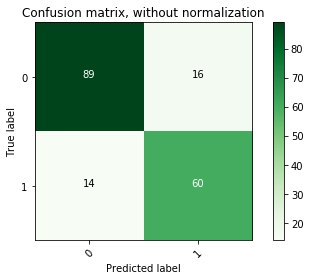

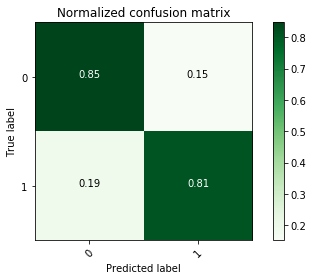

In [551]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, model.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [552]:
model

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42)

In [553]:
from sklearn import grid_search
scorer = make_scorer(fbeta_score, beta=2) # beta of 2 prefers Recall refer to sklearn documentation 
gs = grid_search.GridSearchCV(
    estimator=AdaBoostClassifier(random_state=42),
    param_grid= {'n_estimators' : [90,95,100,105,110]
              ,'learning_rate': [1,1.2,1.4,1.6,1.8]},
    cv=10,
    scoring=scorer)

gs.fit(X_train, y_train)
gs.grid_scores_ 

[mean: 0.76973, std: 0.11025, params: {'learning_rate': 1, 'n_estimators': 90},
 mean: 0.77303, std: 0.10697, params: {'learning_rate': 1, 'n_estimators': 95},
 mean: 0.76930, std: 0.10845, params: {'learning_rate': 1, 'n_estimators': 100},
 mean: 0.76807, std: 0.10728, params: {'learning_rate': 1, 'n_estimators': 105},
 mean: 0.76968, std: 0.10650, params: {'learning_rate': 1, 'n_estimators': 110},
 mean: 0.76529, std: 0.10376, params: {'learning_rate': 1.2, 'n_estimators': 90},
 mean: 0.75969, std: 0.10477, params: {'learning_rate': 1.2, 'n_estimators': 95},
 mean: 0.76143, std: 0.10540, params: {'learning_rate': 1.2, 'n_estimators': 100},
 mean: 0.75410, std: 0.11098, params: {'learning_rate': 1.2, 'n_estimators': 105},
 mean: 0.74949, std: 0.11500, params: {'learning_rate': 1.2, 'n_estimators': 110},
 mean: 0.76284, std: 0.09560, params: {'learning_rate': 1.4, 'n_estimators': 90},
 mean: 0.75774, std: 0.10063, params: {'learning_rate': 1.4, 'n_estimators': 95},
 mean: 0.76323, std:

In [554]:
gs.best_estimator_


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=95, random_state=42)

In [555]:
y_pred = gs.predict(X_test)
paccuracy = accuracy_score(y_test, y_pred)
print((paccuracy))

0.8435754189944135


In [556]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [561]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred).ravel()

In [562]:
confusion

array([91, 14, 14, 60], dtype=int64)

Confusion matrix, without normalization
[[91 14]
 [14 60]]
Normalized confusion matrix
[[0.87 0.13]
 [0.19 0.81]]


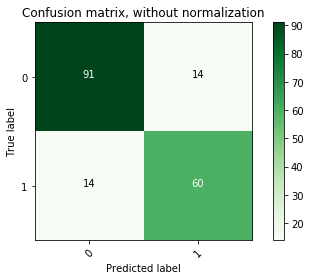

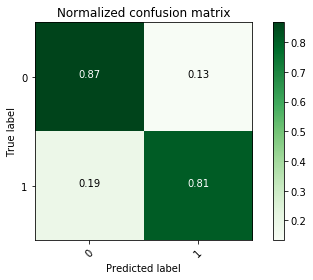

In [563]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [564]:
y_pred_prob = gs.predict_proba(X_test)[:, 1]

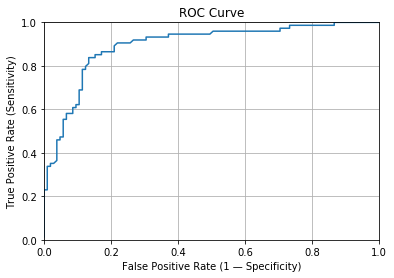

In [569]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 — Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

(0.49, 0.5)

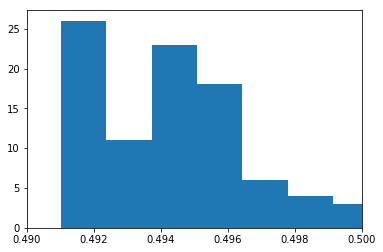

In [570]:
plt.hist(y_pred_prob, bins=150, linewidth=1.2)
plt.xlim(0.49, 0.5)


Text(0,0.5,'Frequency')

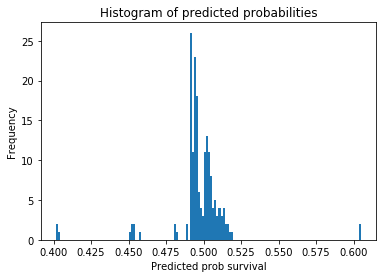

In [571]:
y_pred_prob = gs.predict_proba(X_test)[:, 1]
plt.hist(y_pred_prob, bins=150)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted prob survival')
plt.ylabel('Frequency')

In [ ]:
def evaluate_threshold(threshold):
    print('------')
    print('threshold:'+str(threshold))
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])
    print('------')
for x in np.linspace(0.49,0.5,21):
    evaluate_threshold(x)   
    

def evaluate_threshold(threshold):

    print('threshold:'+str(threshold),
          'Sensitivity:', tpr[thresholds > threshold][-1],
          'Specificity:', 1 - fpr[thresholds > threshold][-1])

for x in np.linspace(0.4955,0.4985,21):
    evaluate_threshold(x)

In [572]:

from sklearn.preprocessing import binarize
y_pred_new = binarize([y_pred_prob],0.4961)[0]
confusion_new = confusion_matrix(y_test, y_pred_new)
print(confusion_new)
print(accuracy_score(y_test, y_pred_new))

[[82 23]
 [ 7 67]]
0.8324022346368715


In [573]:
confusion_new = confusion_matrix(y_test, y_pred_new)
print(confusion_new)

[[81 24]
 [ 7 67]]


Confusion matrix, without normalization
[[82 23]
 [ 7 67]]
Normalized confusion matrix
[[0.78 0.22]
 [0.09 0.91]]


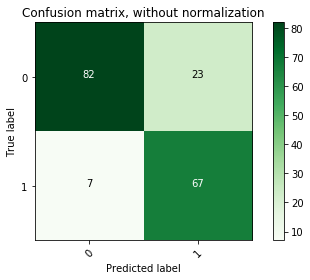

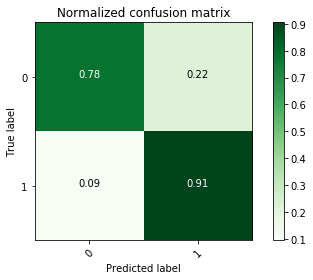

In [575]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_new)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [577]:
from sklearn.metrics import classification_report
report = classification_report(y_pred, y_test)
print(report)

             precision    recall  f1-score   support

          0       0.87      0.87      0.87       105
          1       0.81      0.81      0.81        74

avg / total       0.84      0.84      0.84       179



In [578]:
from sklearn.metrics import classification_report
report = classification_report(y_pred_new, y_test)
print(report)

             precision    recall  f1-score   support

        0.0       0.78      0.92      0.85        89
        1.0       0.91      0.74      0.82        90

avg / total       0.84      0.83      0.83       179



In [579]:
model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=95, random_state=42)

In [580]:
model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=95, random_state=42)

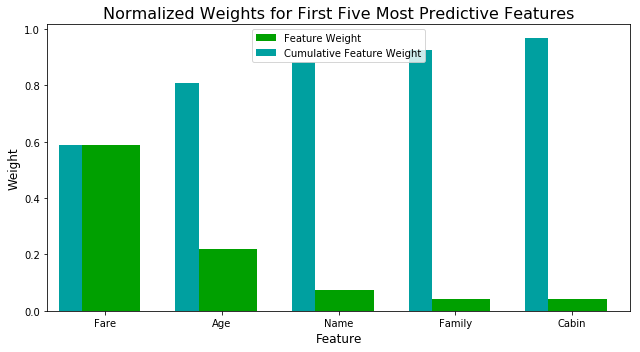

In [581]:
import visuals as vs
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)